In [1]:
import sys,os
sys.path.append(os.path.abspath(".."))

In [2]:
from QuantumWalkModule.OneDimensionQW import *
from QuantumWalkModule.ClassicalWalk import *
import matplotlib.pyplot as plt
from matplotlib import cm

In [19]:
import seaborn as sns
sns.set(style="darkgrid")

In [14]:
plt.rc('font', family='serif')

<h2>Quantum Walk Intro</h2>

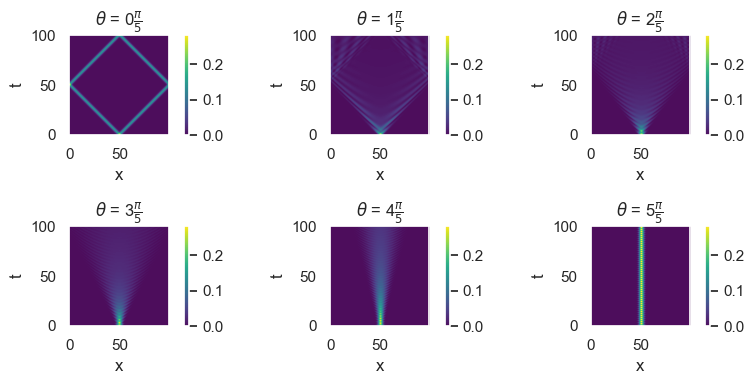

In [20]:
steps = 100
dim = 100
ths = [i * np.pi / 5 for i in range(0,6)]
ths_labels = [r"$\theta$ = " + str(i) + r"$\frac{\pi}{5} $" for i in range(0,6)]

Xsq = torch.ones(size = (steps + 1,dim))
X_ = torch.ones(size = (steps + 1,dim))
for i in range(dim):
    Xsq[:,i] *= i ** 2
    X_[:,i] *= i 

fig = plt.figure(figsize = (8,4))

stds = []

for i,th in enumerate(ths):
    coin_conf = {
        "th" : th
    }
    model = QW_1d(dim , coin_conf)
    data = model.run(steps,state = "Gaussian",mu = dim // 2,sigma = dim /50)
    stds.append(torch.sqrt((Xsq * data).sum(dim = 1) - (X_ * data).sum(dim = 1)**2))

    ax = fig.add_subplot(2,len(ths) // 2,i + 1)
    im = ax.imshow(data, origin = "lower",cmap = "viridis",alpha = 0.95)
    plt.colorbar(im, fraction=0.05, pad=0.09)
    plt.grid(False)
    #sns.heatmap(data.numpy(),ax = ax,linewidths = 0.1, linecolor='black',vmin = 0,vmax = 0.1)
    ax.set_xlabel("x")
    ax.set_ylabel("t")
    ax.set_title(ths_labels[i])
plt.tight_layout()
plt.show()

fig.savefig("Images/QWalks1.pdf",format= "pdf",bbox_inches = "tight")




In [21]:
model_cl = ClWalk(dim)
p = 0.5
data_cl = model_cl.run(p,steps)
std_cl = torch.sqrt((Xsq * data_cl).sum(dim = 1) - (X_ * data_cl).sum(dim = 1)**2)

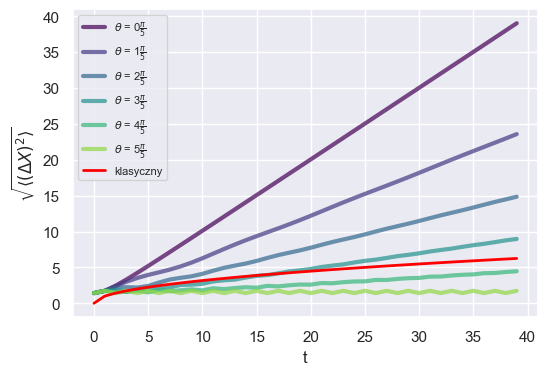

In [23]:
fig = plt.figure(figsize = (6,4))
ax = fig.add_subplot()

color = cm.viridis

for i , std in enumerate(stds):
    #ax.plot(std[:40],color = color(i / len(stds)),label = ths_labels[i],lw = 3,alpha = 0.7)
    sns.lineplot(std[:40],color = color(i / len(stds)),label = ths_labels[i],lw = 3,alpha = 0.7)
    ax.set_xlabel("t")
    ax.set_ylabel(r"$\sqrt{\langle (\Delta X)^{2}\rangle}$")
#ax.plot(std_cl[:40],color = "red",lw = 2,label = "klasyczny")
sns.lineplot(std_cl[:40],color = "red",lw = 2,label = "klasyczny")
plt.legend(fontsize = 8)
plt.show()


fig.savefig("Images/Std_comparison.pdf",format= "pdf",bbox_inches = "tight")

<h2>Quantum Walk with decoherence</h2>

In [24]:
class QW_1d_dm(QW_1d_dm_prototype):
    def get_Kraus(self, **kwargs):
        probs = kwargs.get("probs",[1/3])
        K1 = np.sqrt(probs[0]) * torch.kron(torch.eye(self.dim) , Op.s_l)
        K2 = np.sqrt(probs[0]) * torch.kron(torch.eye(self.dim) , Op.s_r)
        U = np.sqrt(1 - probs[0]) * self.U
        ans = [K1,K2,U]
        return [K1,K2,U]
    
    def make_step(self, rho : torch.tensor, Evo : list):
        return sum(Evo[i] @ rho @ Evo[i].conj().T for i in range(len(Evo)))

In [25]:
def KL_divergence(p : torch.tensor,q : torch.tensor) -> float:
    return (p * torch.where(p > 1e-5, torch.log(p / q),1)).sum().item()

In [26]:
def get_prob_for_pq(th,p):
    assert p >= 0 and p <= 1, "invalid probabilities"

    dim = 100
    coin_conf = {
        "th" : th
    }

    steps = 30
    state_conf = {
        "x0" : dim // 2
    }
    kraus_conf = {
        "probs" : [p]
    }
    
    kwargs_conf = {
        "state" : "Point",
        "state_conf" : state_conf,
        "kraus_conf" : kraus_conf
    }

    model_kraus = QW_1d_dm(dim, coin_conf)
    data = model_kraus.run(steps,**kwargs_conf)
    return data[-1]


In [27]:
model_cl_2 = ClWalk(100)
p = 0.5
data_cl = model_cl_2.run(p,50)
ref_distr = data_cl[-1]

n0 = 0
n_ = 85

ths =  [
    np.pi / 5,    
    2 * np.pi / 5,
    3 * np.pi / 5
    ]
ths_label = [
    r"$\theta = \frac{\pi}{5}$",
    r"$\theta = \frac{2\pi}{5}$",
    r"$\theta = \frac{3\pi}{5}$"
    ]

distrs = []


ans = [np.zeros(n_) for _ in range(len(ths))] 
for j in range(len(ths)):
    distrs.append([])
    for i in range(n_):
        p_distr = get_prob_for_pq(ths[j],i /100)
        distrs[j].append(p_distr)
        ans[j][i] = KL_divergence(ref_distr,p_distr)


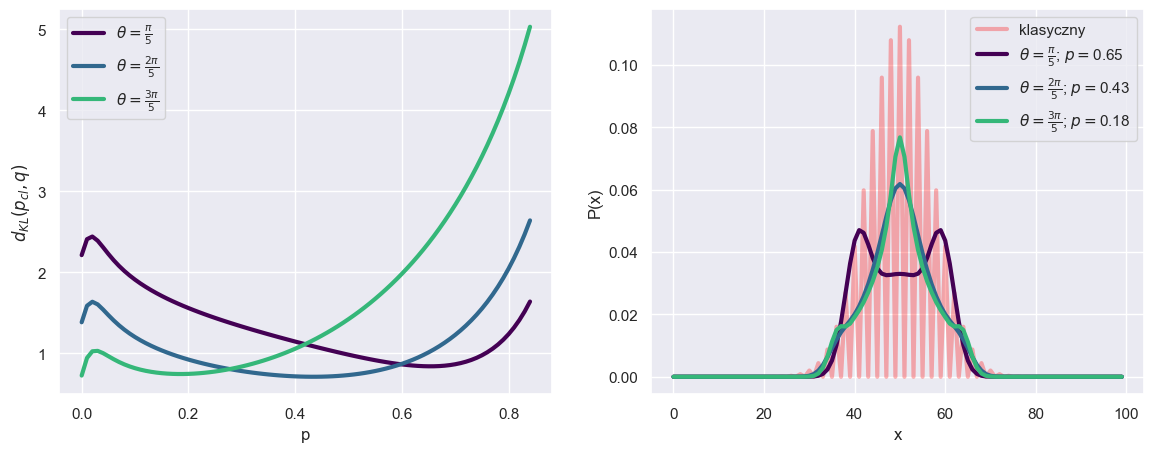

In [28]:
fig = plt.figure(figsize = (14,5))

ax = fig.add_subplot(1,2,1)
p_ = np.arange(0,0.85,0.01)
for i in range(len(ans)):
    ax.plot(p_,ans[i],label = ths_label[i],color = cm.viridis(i / len(ans)), lw = 3)
ax.set_xlabel("p")
ax.set_ylabel(r"$d_{KL}(p_{cl},q)$")
plt.legend()

ax = fig.add_subplot(1,2,2)
maxs = [(np.min(li[5:]),np.argmin(li[5:]) + 5) for li in ans]
ax.plot(ref_distr,color = "red", label = "klasyczny", lw = 3, alpha = 0.3)
for i in range(len(ans)):
    ax.plot(distrs[i][maxs[i][1]], color = cm.viridis(i / len(ans)), label = ths_label[i] + "; " + r"$p = $" + str(maxs[i][1] / 100), lw = 3)
ax.set_xlabel("x")
ax.set_ylabel("P(x)")
plt.legend()
plt.show()

fig.savefig("Images/KL_divergence.pdf",format= "pdf",bbox_inches = "tight")